In [2]:
%load_ext autoreload
%autoreload 2
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import logging
import tensorflow as tf
# gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
# tf.config.experimental.set_virtual_device_configuration(gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2048)])
from train import ABSATrainer
from my_datasets import EnglishDataset, TestTokenizer, ChineseDataset
from transformers import AutoTokenizer, TFAutoModel
from label_mappings import *
from utils.eval_utils import quick_test

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
from models.end_to_end_model import End2EndAspectSentimentModel
init_dir = 'bert_models/bert-base-cased'
init_model = 'bert-base-cased'
# file_path = '../data/semeval2016/ABSA16_Restaurants_Train_SB1_v2.xml'
# tokenizer = AutoTokenizer.from_pretrained('bert-base-cased', cache_dir=init_dir)
# tokenizer.add_special_tokens({'pad_token': '[PAD]'})
# dataset = SemEvalDataSet(file_path, tokenizer, sentence_b=ASPECT_SENTENCE, model_type="end_to_end")
# ds = tf.data.Dataset.from_generator(
#     dataset.generate_string_sample,
#     output_types=(tf.string, tf.string)
# ).batch(batch_size=8).map(dataset.wrap_map)
model = End2EndAspectSentimentModel(init_bert_model=init_model, sentence_b=ASPECT_SENTENCE, cache_dir=init_dir, hot_attention=True, fuse_strategy="gate")

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [34]:
dummy_inputs = tf.ones([1,10,768])
model.self_attention(dummy_inputs, attention_mask=None, head_mask=None, output_attentions=False)
model.self_attention.get_weights()
model.self_attention.set_weights(model.bert.bert.encoder.layer[-1].attention.get_weights())

In [40]:
[a == b for a, b in zip(model.self_attention.get_weights(), model.bert.bert.encoder.layer[-1].attention.get_weights())]

[array([[[ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         ...,
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True]],
 
        [[ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         ...,
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True]],
 
        [[ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         ...,
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True, 

[array([[[ 1.02498438e-02, -1.43570416e-02, -1.80756804e-02, ...,
          -2.78780586e-03,  1.07989367e-02,  5.83254471e-02],
         [ 1.92327071e-02, -7.29055405e-02,  1.60758235e-02, ...,
           4.86904718e-02,  1.70751642e-02,  3.89212295e-02],
         [-2.43399572e-02, -4.49416880e-03, -6.77823648e-03, ...,
           3.24892402e-02, -3.72769944e-02, -2.33927835e-02],
         ...,
         [-2.04806011e-02,  4.71325032e-02,  4.79608476e-02, ...,
          -4.58024964e-02, -2.12218743e-02,  3.70215029e-02],
         [-3.78619954e-02,  3.74984778e-02,  3.00552733e-02, ...,
           5.81883974e-02,  1.32160820e-03, -2.91755181e-02],
         [ 8.68315324e-02,  2.34909691e-02,  2.22777855e-02, ...,
          -7.38291070e-02, -2.20611226e-02,  1.14350859e-02]],
 
        [[ 8.60391092e-03,  5.62237948e-02, -1.13334128e-04, ...,
           5.12356199e-02,  3.40097174e-02,  1.03171645e-02],
         [ 4.06599045e-02,  1.75750125e-02, -1.01442985e-01, ...,
           3.16407979

In [50]:
# single tower english
model_type = "single_tower"
cased = True
mask_sb = True


init_dir = '../models/bert-base-cased'
init_model = 'bert-base-cased'
data_path = 'data/semeval2016/ABSA16_Restaurants_Train_SB1_v2.xml'
checkpoint_path = "./checkpoint/v0_256_1_30_cased_mask_b_avg_loss_aug_2/"
lang = "en"

# checkpoint_path = 
# test_path = "./data/semeval2016/EN_REST_SB1_TEST_LABELED.xml"
test_path = None
tokenizer = AutoTokenizer.from_pretrained(init_model, cache_dir=init_dir)
tokenizer.add_special_tokens({'pad_token': '[PAD]'})
# test_dataset = ChineseDataset(test_path, tokenizer, ASPECT_SENTENCE, mask_sb, model_type)

trainer = ABSATrainer(
    None,
    data_path,
    test_path,
    logger=logging.getLogger(),
    checkpoint=checkpoint_path,
    cased=cased,
    model_type=model_type,
    mask_sb=mask_sb,
    lang=lang
)

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [5]:
# end to end 
cased = True
mask_sb = True
model_type = "end_to_end"



init_dir = '../models/bert-base-cased'
init_model = 'bert-base-cased'
data_path = 'data/semeval2016/ABSA16_Restaurants_Train_SB1_v2.xml'
test_path = 'data/semeval2016/EN_REST_SB1_TEST_LABELED.xml'
checkpoint_path = "./checkpoint/v2_e2e_30_2_layer_pool_256_h_aug23/"
# checkpoint_path = "./checkpoint/v2_e2e_30_2_layer_pool_256_h_aug23/"
# checkpoint_path = "./checkpoint/v2_e2e_30_2_layer_pool_256_h_aug2_2e-5_cased_dropout/"
# checkpoint_path = "./checkpoint/v2_e2e_50_2_layer_pool_256_h_2e-5_aug2_cased_update_dropout_0.1_drop_null_cache_aspsenti"
lang = "en"

# init_dir = '../models/bert-base-chinese'
# init_model = 'bert-base-chinese'
# data_path = 'data/semeval2016/phone_chinese/labeled_phone.csv'
# checkpoint_path = "./checkpoint/cn_e2e_30_2_layer_pool_256_h_aug23"
# lang = "cn"
# test_path = None



tokenizer = AutoTokenizer.from_pretrained(init_model, cache_dir=init_dir)
tokenizer.add_special_tokens({'pad_token': '[PAD]'})
# test_dataset = ChineseDataset(test_path, tokenizer, ASPECT_SENTENCE, mask_sb, model_type)

trainer = ABSATrainer(
    None,
    data_path,
    test_path,
    logger=logging.getLogger(),
    checkpoint=checkpoint_path,
    cased=cased,
    model_type=model_type,
    mask_sb=mask_sb,
    lang=lang
)
# test_tokenizer = TestTokenizer(trainer.tokenizer, ASPECT_SENTENCE_CHINESE, mask_sb, model_type)
test_tokenizer = TestTokenizer(trainer.tokenizer, ASPECT_SENTENCE, mask_sb, model_type)

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [3]:
# cf = {"init_bert_model": "bert-base-cased", "sentence_b": {"texts": ["general of ambience", "price of drinks", "quality of drinks", "style options of drinks", "prices of food", "quality of food", "style options of food", "general of location", "general of restaurant", "miscellaneous of restaurant", "prices of restaurant", "general of service"], "sentiments": ["negative", "neutral", "positive"]}, "num_sentiment_classes": 3, "subblock_hidden_size": 256, "subblock_head_num": 1, "cache_dir": "../models/bert-base-cased", "fuse_strategy": "concat"}
# trainer_2 = ABSATrainer(
#     None,
#     data_path,
#     test_path,
#     logger=logging.getLogger(),
#     checkpoint=None,
#     cased=cased,
#     model_type=model_type,
#     mask_sb=mask_sb,
#     config=cf
# )

In [13]:
test_data = [
    "Comfortable sofa and chairs, good hamburgers. But the waiter is very rude."
]
# data = test_tokenizer.tokenize(test_data)
# inputs = [data['input_ids'], data['token_type_ids'], data['attention_mask']]
# aspect_inputs = [data['aspect_input_ids'], data['aspect_token_type_ids'], data['aspect_attention_mask']]
# trainer.model(inputs, aspect_inputs, phase="test")

In [14]:
res, _ = quick_test(test_data, test_tokenizer, trainer, output_attentions=True)
res

[[{"target": "chairs", "aspect": "AMBIENCE#GENERAL", "polarity": "positive", "prob": 0.9267281889915466},
  {"target": "waiter", "aspect": "SERVICE#GENERAL", "polarity": "negative", "prob": 0.9998960494995117},
  {"target": "sofa", "aspect": "AMBIENCE#GENERAL", "polarity": "positive", "prob": 0.23541374504566193},
  {"target": "hamburgers", "aspect": "FOOD#QUALITY", "polarity": "positive", "prob": 0.9992883205413818}]]

In [19]:
signatures = {
    "text_inputs": [tf.TensorSpec(shape=(None, None), dtype=tf.int32), tf.TensorSpec(shape=(None, None), dtype=tf.int32), tf.TensorSpec(shape=(None, None, None), dtype=tf.int32)],
    "aspect_inputs": [tf.TensorSpec(shape=(None, None), dtype=tf.int32), tf.TensorSpec(shape=(None, None), dtype=tf.int32), tf.TensorSpec(shape=(None, None), dtype=tf.int32)]
}
test_func = trainer.model.call.get_concrete_function(text_inputs=signatures['text_inputs'], aspect_inputs=signatures['aspect_inputs'], label_inputs=None, phase="test", output_attentions=False)
tf.saved_model.save(trainer.model, "./saved_models/en_aug23_cache", signatures=test_func)

The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.
The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.
The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.
The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.
T

INFO:tensorflow:Assets written to: ./saved_models/en_aug23_cache/assets


INFO:tensorflow:Assets written to: ./saved_models/en_aug23_cache/assets


In [18]:
tokenized_data = test_tokenizer.tokenize(["Good drinks"])
text_inputs = [tokenized_data['input_ids'], tokenized_data['token_type_ids'], tokenized_data['attention_mask']]
aspect_inputs = [tokenized_data['aspect_input_ids'], tokenized_data['aspect_token_type_ids'], tokenized_data['aspect_attention_mask']]

In [66]:
res = infer_model.call(text_inputs=text_inputs, aspect_inputs=aspect_inputs, label_inputs=None, phase="test", output_attentions=True)

In [31]:
import requests
import json
test_data = {"text": ["Comfortable sofa and chairs, good hamburgers. But the waiter is very rude."],
        "language": "en",
        "output_attentions": False,
}
url = "http://127.0.0.1:3030/absa_service"
# res = test_to|kenizer.tokenizer(test_data, padding="max_length", max_length=64)
res = requests.post(url, json=test_data)
res.json()

{'origin_text': ['Comfortable sofa and chairs, good hamburgers. But the waiter is very rude.'],
 'result': [[{'target': 'sofa',
    'aspect': 'AMBIENCE#GENERAL',
    'polarity': 'positive',
    'prob': 0.23541486263275146},
   {'target': 'hamburgers',
    'aspect': 'FOOD#QUALITY',
    'polarity': 'positive',
    'prob': 0.9992883205413818},
   {'target': 'waiter',
    'aspect': 'SERVICE#GENERAL',
    'polarity': 'negative',
    'prob': 0.9998960494995117},
   {'target': 'chairs',
    'aspect': 'AMBIENCE#GENERAL',
    'polarity': 'positive',
    'prob': 0.9267282485961914}]],
 'time_cost': 0.28431248664855957,
 'status': 'success',
 'error_code': 0}

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

test_data = [
    "Comfortable sofa and chairs, good hamburgers. But the waiter is very rude."
#     "The hamburger taste good but is too expensive",
#     "The hamburger tastes good but it is too expensive!",
]
query_inputs = tokenizer.tokenize('[CLS]', add_special_tokens=False)
key_inputs = tokenizer.tokenize(test_data[0], add_special_tokens=True)
res, out = quick_test(test_data, test_tokenizer, trainer, output_attentions=True)
res

In [257]:
at = res['sc_attention']
at_list = []

for i in range(at.size()):
    at_list.append(at.read(i).numpy())

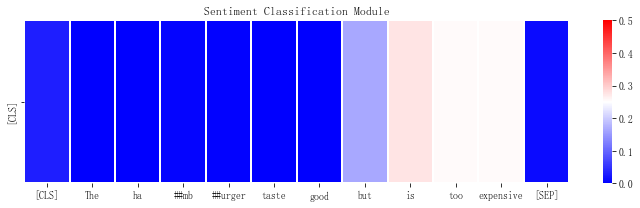

In [260]:
# % matplotlib inline
query_inputs = tokenizer.tokenize('[CLS]', add_special_tokens=False)
key_inputs = tokenizer.tokenize(test_data[0], add_special_tokens=True)
attention = at_list[1].squeeze(0).squeeze(0)[:, :len(key_inputs)]
df = pd.DataFrame(attention)
df.columns = key_inputs
df.index = query_inputs
plt.figure(figsize=(10, 3))
sns.heatmap(df, linewidths = 0.1, vmax=0.5, vmin=0, cmap="bwr")
plt.title("Sentiment Classification Module")
plt.tight_layout()
# plt.savefig('./plots/bwr_ham_sc_attention.jpg', dpi=300)
plt.show()
# print(attention)

In [41]:
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pandas as pd
import numpy as np
from label_mappings import CATEGORY_LABEL_MAPPING_CHINESE, SENTIMENT_LABEL_MAPPING_CHINESE, CATEGORY_LABEL_MAPPING, SENTIMENT_LABEL_MAPPING
matplotlib.rcParams['axes.unicode_minus']=False
matplotlib.rcParams['font.sans-serif'] = ['FangSong']

# % matplotlib inline
# test_data = [
# #     "Comfortable sofa and chairs, good hamburgers. But the waiter is very rude."
# #     "The hamburger taste good but is too expensive",
# #     "The hamburger tastes good but it is too expensive!",
#     "屏幕质量不错，很抗摔；电池续航很好，可以待机两天；相机不是很给，拍出来有点模糊"
# ]

data = {"text": [
        "屏幕质量不错，很抗摔；电池续航很好，可以待机两天；相机不是很给，拍出来有点模糊"
                ],
        "language": "en",
        "output_attentions": True,
}

query_inputs = tokenizer.tokenize('[CLS]', add_special_tokens=False)
key_inputs = tokenizer.tokenize(test_data["text"][0], add_special_tokens=True)

res = requests.post(url, json=data).json()
# res, attention = quick_test(test_data, test_tokenizer, trainer, output_attentions=True)
# res

dict_keys(['origin_text', 'result', 'time_cost', 'status', 'attentions', 'error_code'])

In [42]:
asp_idxs = []
query_inputs = []
# for triplet in res[0]:
#     asp_idx = CATEGORY_LABEL_MAPPING[triplet.aspect]
#     senti_idx = SENTIMENT_LABEL_MAPPING[triplet.sentiment]
#     asp_idxs.append(asp_idx * 3 + senti_idx)
#     query_inputs.append(triplet.aspect + "_" + triplet.sentiment)
for asp in CATEGORY_LABEL_MAPPING_CHINESE:
    for senti in SENTIMENT_LABEL_MAPPING_CHINESE:
        query_inputs.append(asp + "_" + senti)

sim_matrix = np.array(res['attentions']).squeeze() #[np.array(asp_idxs)]
df = pd.DataFrame(sim_matrix)
df.index = query_inputs
df.columns = key_inputs
plt.figure(figsize=(20, 10))
sns.heatmap(df, linewidths = 0.1, vmax=1, vmin=-1, cmap="bwr")
plt.title("Cosine Simlarity in FuseBlock")
plt.tight_layout()
# plt.savefig('./plots/fusebock_sim_matrix_cn_all_3t.jpg', dpi=300)
plt.show()
# print(attention)

ValueError: Length mismatch: Expected axis has 36 elements, new values have 33 elements